In [1]:
from collections import Counter
from gensim.corpora import Dictionary
from nltk import ngrams
from scipy import stats

import itertools
import numpy as np
import os
import pybo
import re

import matplotlib.pyplot as plt
%matplotlib inline

Store texts in the following directory structure:

    texts
      Bon
        file1.txt
        file2.txt
        ...
      Nyingma
        file1.txt
        file2.txt
        ...

In [2]:
tok = pybo.BoTokenizer('POS')

Loading Trie...
Time: 7.253414869308472


Assumptions here:
1. Drop all non-bo text
2. Drop all phrase delimiters (shad)
3. Reduce words to lemmas
4. Strip beginning and ending tseks from lemmas

In [3]:
tsek = '་'
filter_list = ['གི','ལ','གིས','དང','ནི','ནས','པ','གོ','ཀྱང','དུ','ཀྱིས','དེ','ཏེ','མ','སྟེ','སུ','ཀྱི','གྱིས','ན','ཅེས','འདི','གྱི','ཅི','བ','པར','ཡིས','ཅིང','མོ','ཅེས་པ','རྣམས','ཏུ']

def read_texts(text_dir):
    fnames = []
    texts = []
    texts_f = []
    bigrams = []
    bigrams_f = []
    
    for filename in sorted(os.listdir(text_dir)):
        if ".txt" in filename:
            with open(os.path.join(text_dir, filename), 'r', encoding='utf-8-sig') as f:
                fnames.append(filename)
                tokens = [t for t in tok.tokenize(f.read()) if t.type != "non-bo" and t.pos != "punct"]
                
                lemmas = [t.lemma.strip(tsek) if t.lemma else t.content.strip(tsek) for t in tokens]
                texts.append(lemmas)
                
                lemmas_f = [l for l in lemmas if l not in filter_list]
                texts_f.append(lemmas_f)
                
                grams = [tsek.join(x) for x in ngrams(lemmas, 2)]
                bigrams.append(grams)
                
                grams_f = [tsek.join(x) for x in ngrams(lemmas, 2) if not set(x).intersection(filter_list)]
                bigrams_f.append(grams_f)
            
    return texts, texts_f, bigrams, bigrams_f, fnames

In [4]:
def vectorize_texts(texts, dct):
    vecs = []
    for t in texts:
        vec = np.zeros(len(dct))
        bow = dct.doc2bow(t)
        for k, v in bow:
            vec[k] = v
        vecs.append(vec)
    return vecs

In [5]:
def cos_sim(u, v):
    n_u = np.linalg.norm(u)
    n_v = np.linalg.norm(v)
    if n_u == 0 or n_v == 0:
        return 0
    return (u / n_u).dot(v / n_v)
  
def plot_one(c1, c2, c1_files, c2_files, k, c1_name, c2_name, c1_second, c2_second, abs_color):
    X = np.zeros((len(c1), len(c2)))
    
    for i in range(len(c1)):
        for j in range(len(c2)):
            if c1_second:
                u1 = c1[i]
                u2 = c1_second[i]
                v1 = c2[j]
                v2 = c2_second[j]
                sim = (k(u1, v1) + k(u2, v2)) / 2
            else:
                u = c1[i]
                v = c2[j]
                sim = k(u, v)
            X[i,j] = sim
            
    # Set axes
    figs, axs = plt.subplots(figsize=(10,10))
    if abs_color:
        axs.imshow(X, cmap="hot", vmin=0, vmax=1, interpolation='none')
    else:
        axs.imshow(X, cmap="hot", interpolation='none')        
    axs.set_aspect('equal')

    # put the major ticks at the middle of each cell
    axs.set_xticks(np.arange(X.shape[1]), minor=False)
    axs.set_yticks(np.arange(X.shape[0]), minor=False)

    # want a more natural, table-like display
    axs.xaxis.tick_top()

    axs.set_xticklabels(c2_files, minor=False)
    axs.set_yticklabels(c1_files, minor=False)
    
    for label in axs.get_xmajorticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment("left")
    
    plt.show()
    print("{} vs {}".format(c1_name, c2_name))
    
def plot_all(c1, c2, c1_files, c2_files, k, c1_name, c2_name, c1_second, c2_second, abs_color):
    plot_one(c1, c1, c1_files, c1_files, k, c1_name, c1_name, c1_second, c1_second, abs_color)
    plot_one(c2, c2, c2_files, c2_files, k, c2_name, c2_name, c2_second, c2_second, abs_color)
    plot_one(c1, c2, c1_files, c2_files, k, c1_name, c2_name, c1_second, c2_second, abs_color)
    

In [6]:
def run_one(c1_texts, c2_texts, c1_name, c2_name, c1_fnames, c2_fnames, c1_bigrams=[], c2_bigrams=[], abs_color=False):
    dct = Dictionary(c1_texts + c2_texts + c1_bigrams + c2_bigrams)
    c1 = vectorize_texts(c1_texts, dct)
    c2 = vectorize_texts(c2_texts, dct)
    c1_second = vectorize_texts(c1_bigrams, dct) if c1_bigrams else None
    c2_second = vectorize_texts(c2_bigrams, dct) if c2_bigrams else None
    plot_one(c1, c2, c1_fnames, c2_fnames, k=cos_sim, c1_name=c1_name, c2_name=c2_name, c1_second=c1_second, c2_second=c2_second, abs_color=abs_color)
    

In [7]:
bon_texts, bon_texts_f, bon_bigrams, bon_bigrams_f, bon_fnames = read_texts("texts/Bon")
nyingma_texts, nyingma_texts_f, nyingma_bigrams, nyingma_bigrams_f, nyingma_fnames = read_texts("texts/Nyingma")
bon_large_texts, bon_large_texts_f, bon_large_bigrams, bon_large_bigrams_f, bon_large_fnames = read_texts("texts/Bon-Large")
nyingma_large_texts, nyingma_large_texts_f, nyingma_large_bigrams, nyingma_large_bigrams_f, nyingma_large_fnames = read_texts("texts/Nyingma-Large")
bon_dzogchen_texts, bon_dzogchen_texts_f, bon_dzogchen_bigrams, bon_dzogchen_bigrams_f, bon_dzogchen_fnames = read_texts("texts/Bon-Dzogchen")
nyingma_dzogchen_texts, nyingma_dzogchen_texts_f, nyingma_dzogchen_bigrams, nyingma_dzogchen_bigrams_f, nyingma_dzogchen_fnames = read_texts("texts/Nyingma-Dzogchen")
nyingma_gn_texts, nyingma_gn_texts_f, nyingma_gn_bigrams, nyingma_gn_bigrams_f, nyingma_gn_fnames = read_texts("texts/Nyingma-GN")
news_texts, news_texts_f, news_bigrams, news_bigrams_f, news_fnames = read_texts("texts/News")
mahamudra_texts, mahamudra_texts_f, mahamudra_bigrams, mahamudra_bigrams_f, mahamudra_fnames = read_texts("texts/Mahamudra")
vairo_texts, vairo_texts_f, vairo_bigrams, vairo_bigrams_f, vairo_fnames = read_texts("texts/Vairo")
chan_texts, chan_texts_f, chan_bigrams, chan_bigrams_f, chan_fnames = read_texts("texts/Dunhuang-Chan")
dunhuang_texts, dunhuang_texts_f, dunhuang_bigrams, dunhuang_bigrams_f, dunhuang_fnames = read_texts("texts/Dunhuang")


# Filtered vocabulary

## Bon vs self

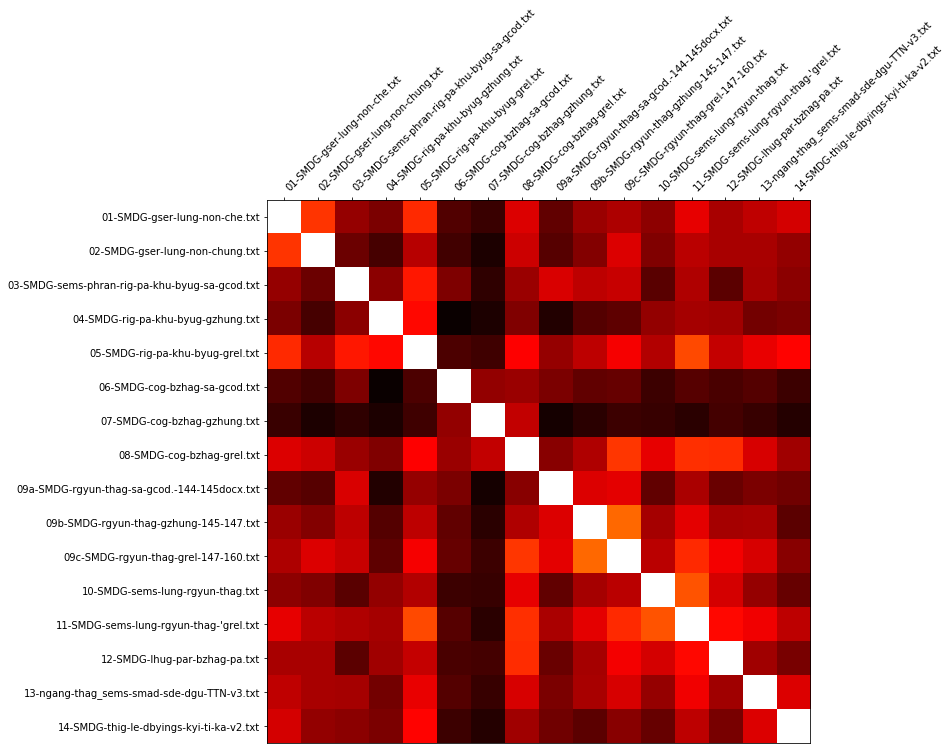

Bon vs Bon


In [8]:
run_one(bon_texts_f, bon_texts_f, "Bon", "Bon", bon_fnames, bon_fnames, bon_bigrams_f, bon_bigrams_f)

## Nyingma vs self

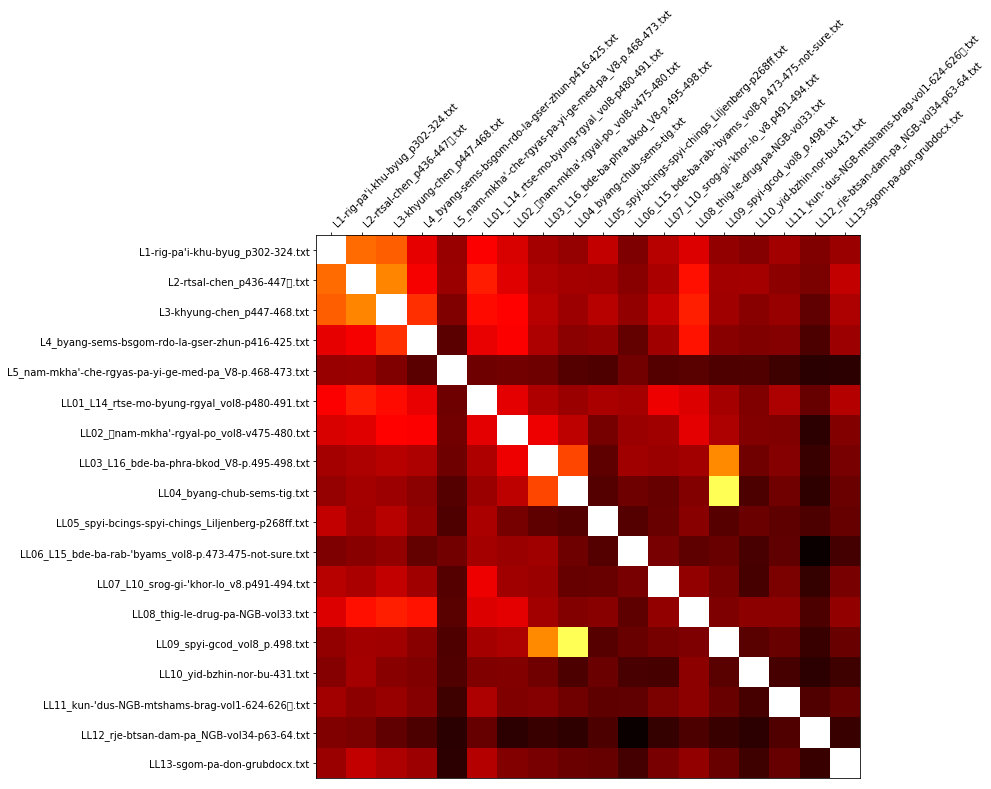

Nyingma vs Nyingma


In [9]:
run_one(nyingma_texts_f, nyingma_texts_f, "Nyingma", "Nyingma", nyingma_fnames, nyingma_fnames, nyingma_bigrams_f, nyingma_bigrams_f)

## Nyingma vs Gdams Ngag songs (relative)

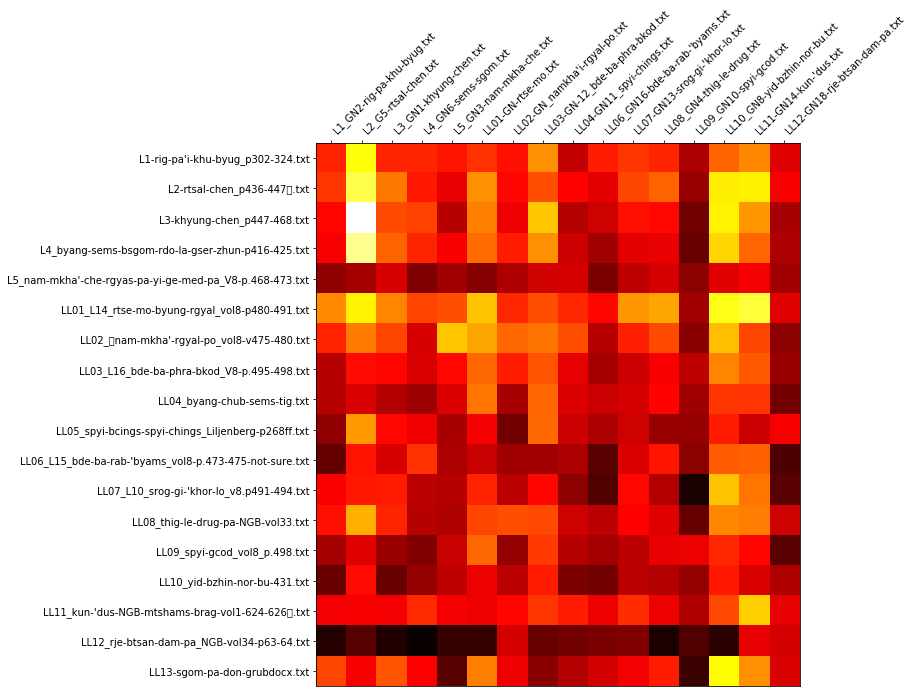

Nyingma vs Nyingma Gdams Ngag


In [10]:
run_one(nyingma_texts_f, nyingma_gn_texts_f, "Nyingma", "Nyingma Gdams Ngag", nyingma_fnames, nyingma_gn_fnames, nyingma_bigrams_f, nyingma_gn_bigrams_f)

## Nyingma vs Gdams Ngag songs (absolute)

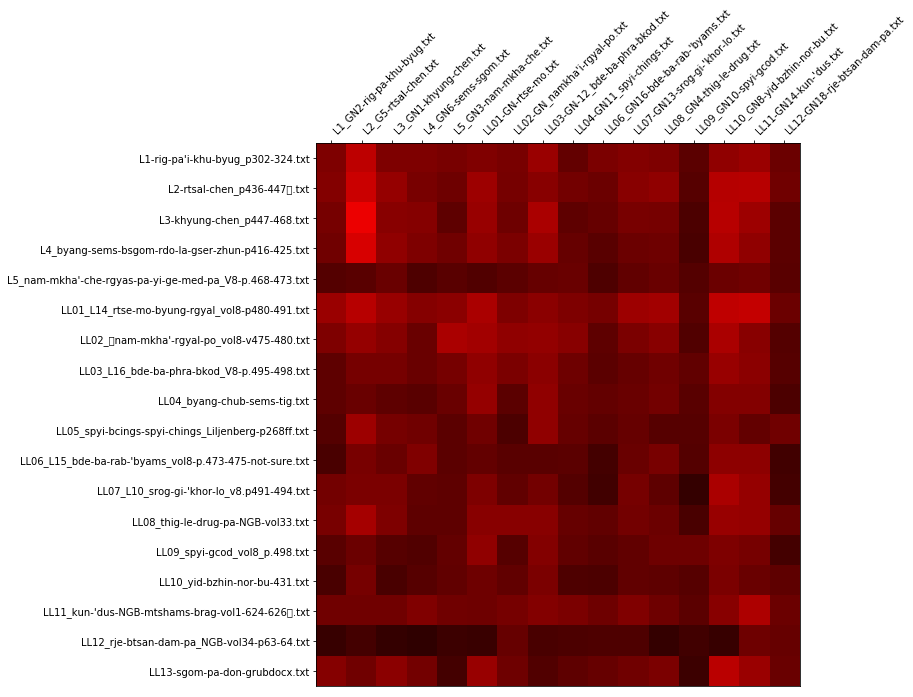

Nyingma vs Nyingma Gdams Ngag


In [11]:
run_one(nyingma_texts_f, nyingma_gn_texts_f, "Nyingma", "Nyingma Gdams Ngag", nyingma_fnames, nyingma_gn_fnames, nyingma_bigrams_f, nyingma_gn_bigrams_f, abs_color=True)

## 5 earlier Nyingma vs Vairo (relative)

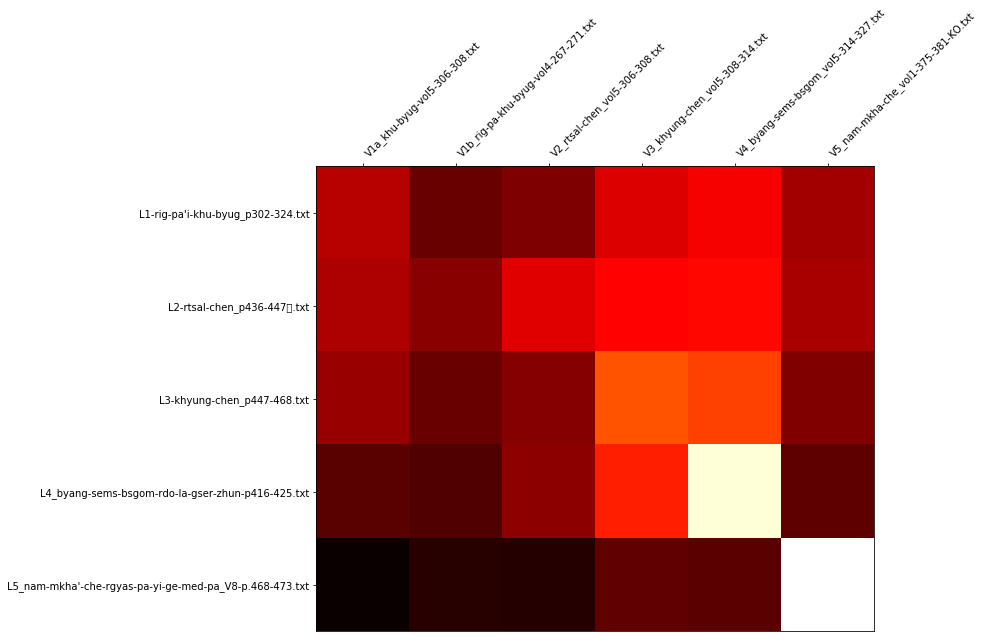

5 earlier Nyingma vs Vairo


In [12]:
run_one(nyingma_texts_f[:5], vairo_texts_f, "5 earlier Nyingma", "Vairo", nyingma_fnames[:5], vairo_fnames, nyingma_bigrams_f[:5], vairo_bigrams_f)

## 5 earlier Nyingma vs Vairo (absolute)

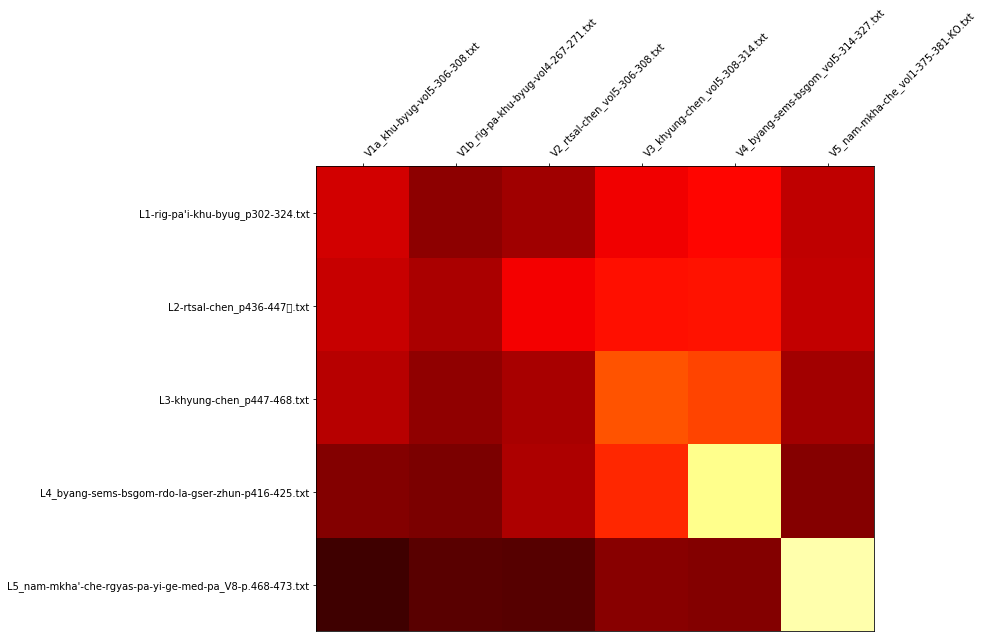

5 earlier Nyingma vs Vairo


In [13]:
run_one(nyingma_texts_f[:5], vairo_texts_f, "5 earlier Nyingma", "Vairo", nyingma_fnames[:5], vairo_fnames, nyingma_bigrams_f[:5], vairo_bigrams_f, abs_color=True)

## 5 earlier Nyingma vs Bon (relative)

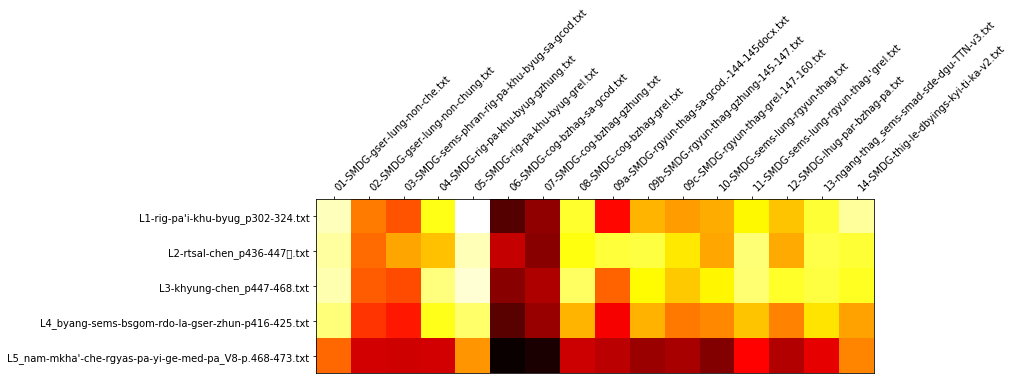

5 earlier Nyingma vs Bon


In [14]:
run_one(nyingma_texts_f[:5], bon_texts_f, "5 earlier Nyingma", "Bon", nyingma_fnames[:5], bon_fnames, nyingma_bigrams_f[:5], bon_bigrams_f)

## 5 earlier Nyingma vs Bon (absolute)

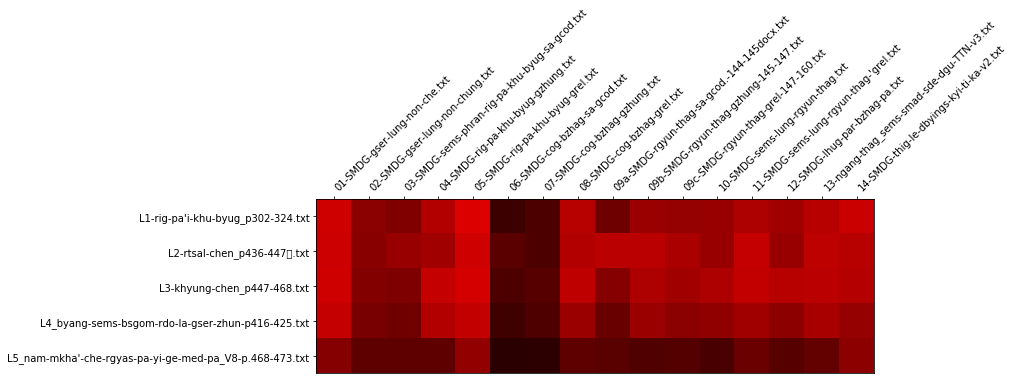

5 earlier Nyingma vs Bon


In [15]:
run_one(nyingma_texts_f[:5], bon_texts_f, "5 earlier Nyingma", "Bon", nyingma_fnames[:5], bon_fnames, nyingma_bigrams_f[:5], bon_bigrams_f, abs_color=True)

##  Vairo vs Bon (relative)

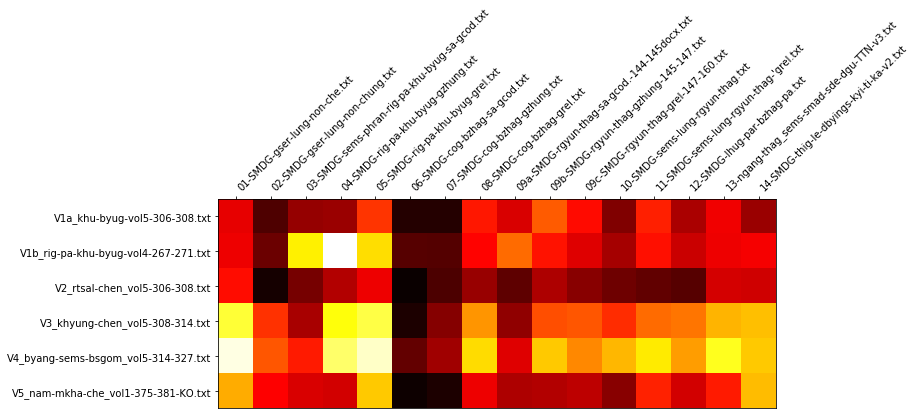

Vairo vs Bon


In [16]:
run_one(vairo_texts_f, bon_texts_f, "Vairo", "Bon", vairo_fnames, bon_fnames, vairo_bigrams_f, bon_bigrams_f)

##  Vairo vs Bon (absolute)

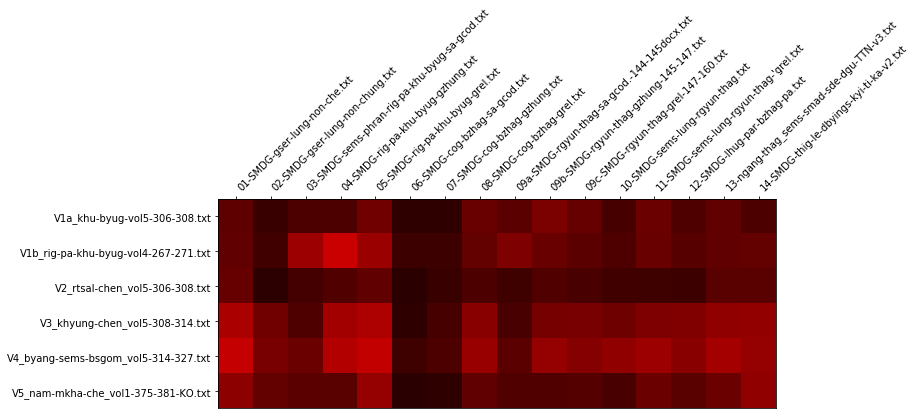

Vairo vs Bon


In [17]:
run_one(vairo_texts_f, bon_texts_f, "Vairo", "Bon", vairo_fnames, bon_fnames, vairo_bigrams_f, bon_bigrams_f, abs_color=True)

## Bon vs Nyingma (relative)

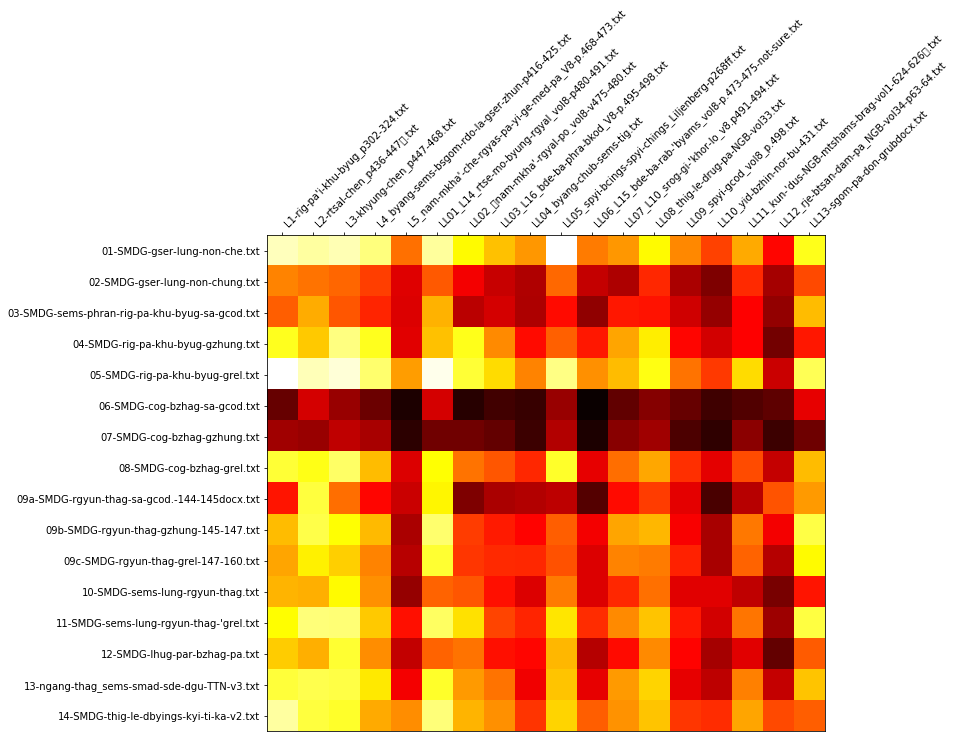

Bon vs Nyingma


In [18]:
run_one(bon_texts_f, nyingma_texts_f, "Bon", "Nyingma", bon_fnames, nyingma_fnames, bon_bigrams_f, nyingma_bigrams_f)

## Bon vs Nyingma (absolute)

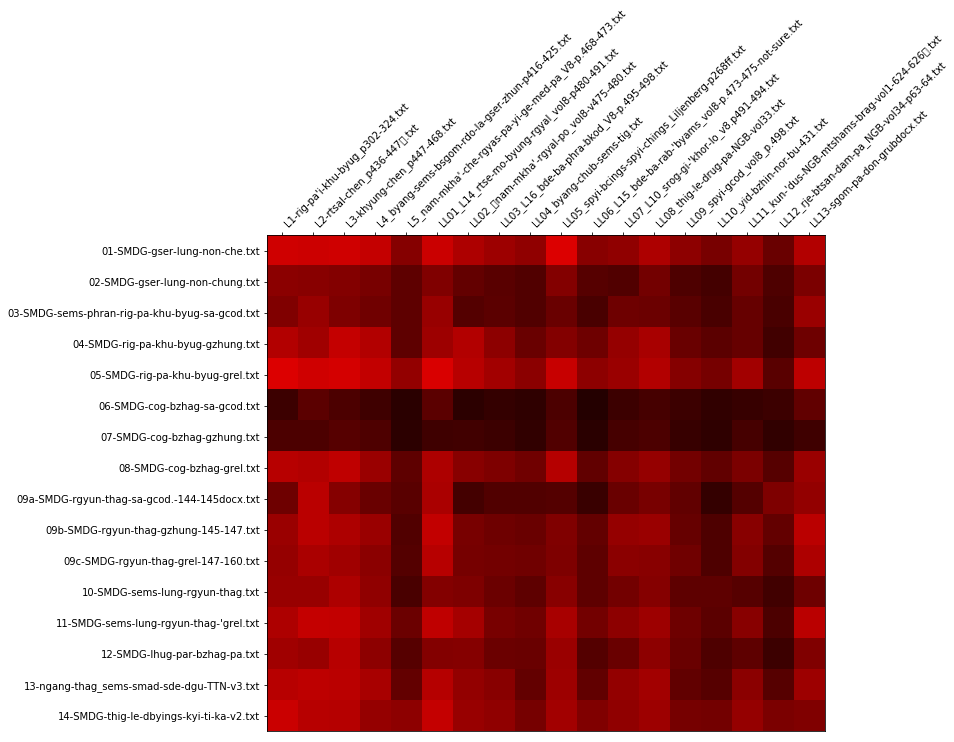

Bon vs Nyingma


In [19]:
run_one(bon_texts_f, nyingma_texts_f, "Bon", "Nyingma", bon_fnames, nyingma_fnames, bon_bigrams_f, nyingma_bigrams_f, abs_color=True)

## Bon + Bon large vs Nyingma + Nyingma large (relative)

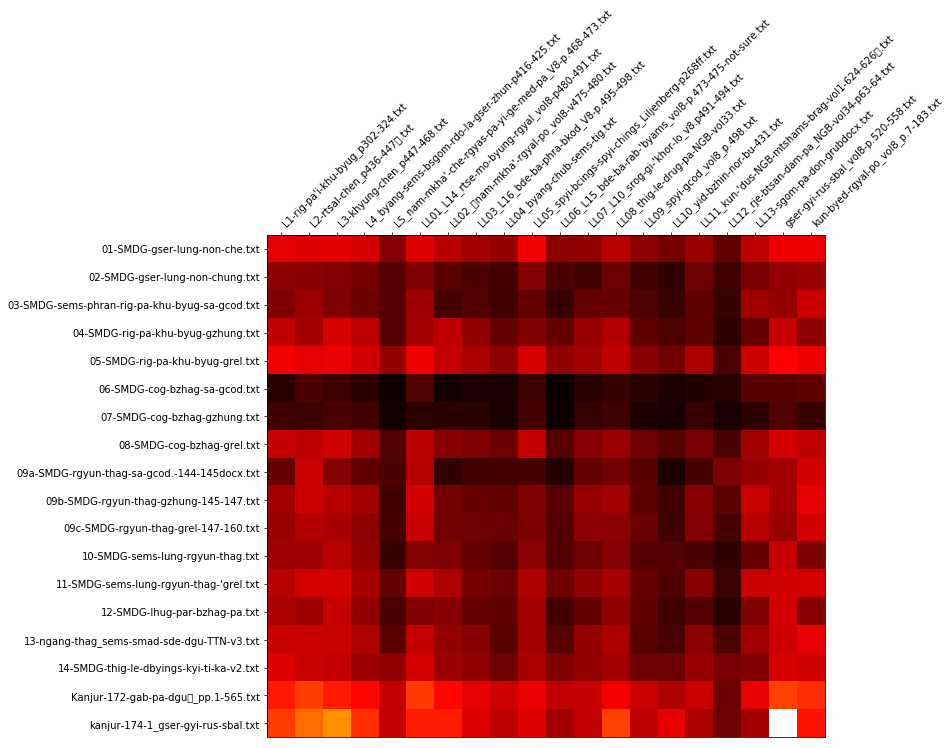

Bon + Bon large vs Nyingma + Nyingma large


In [20]:
run_one(bon_texts_f + bon_large_texts_f, nyingma_texts_f + nyingma_large_texts_f, "Bon + Bon large", "Nyingma + Nyingma large", bon_fnames + bon_large_fnames, nyingma_fnames + nyingma_large_fnames, bon_bigrams_f + bon_large_bigrams_f, nyingma_bigrams_f + nyingma_large_bigrams_f)

## Bon + Bon large vs Nyingma + Nyingma large (absolute)

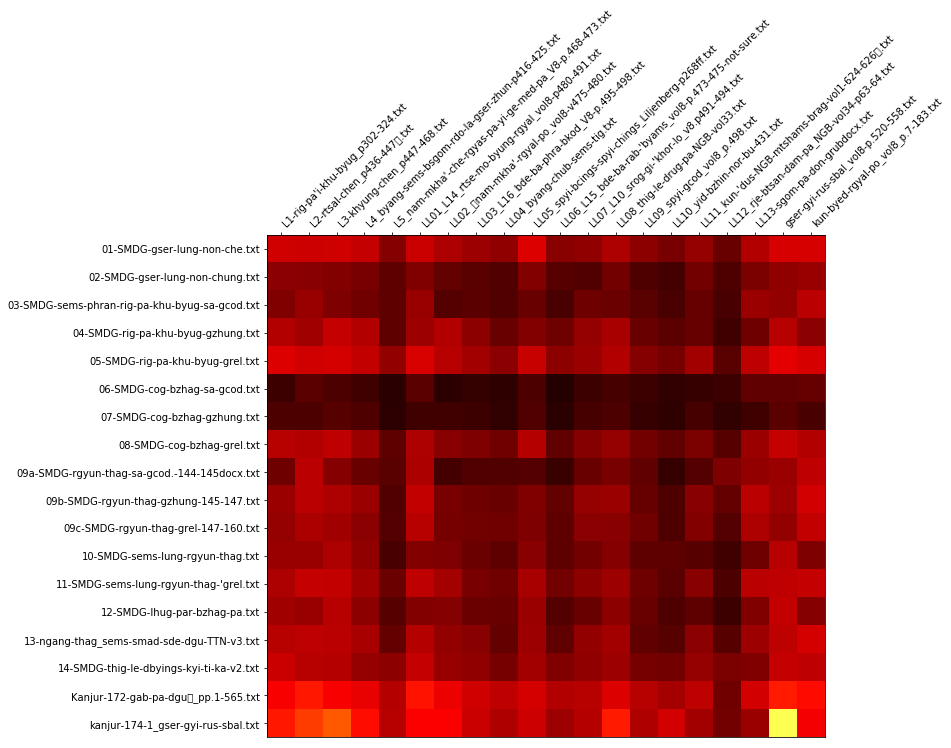

Bon + Bon large vs Nyingma + Nyingma large


In [21]:
run_one(bon_texts_f + bon_large_texts_f, nyingma_texts_f + nyingma_large_texts_f, "Bon + Bon large", "Nyingma + Nyingma large", bon_fnames + bon_large_fnames, nyingma_fnames + nyingma_large_fnames, bon_bigrams_f + bon_large_bigrams_f, nyingma_bigrams_f + nyingma_large_bigrams_f, abs_color=True)

## Bon + Bon large + Bon dzogchen + Mahamudra + Dunhuang Chan vs Nyingma + Nyingma large + Nyingma dzogchen + Mahamudra + Dunhuang Chan

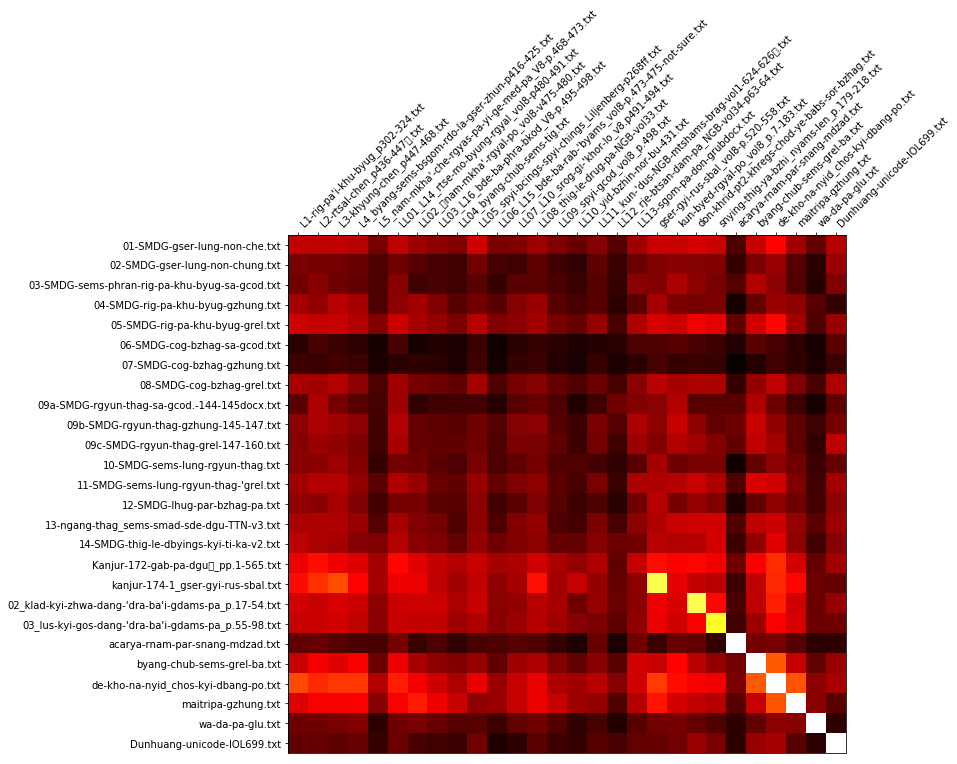

Bon + Bon large + Bon Dzogchen + Mahamudra + Dunhuang Chan vs Nyingma + Nyingma large + Nyingma Dzogchen + Mahamudra + Dunhuang Chan


In [22]:
run_one(bon_texts_f + bon_large_texts_f + bon_dzogchen_texts_f + mahamudra_texts_f + chan_texts_f,
        nyingma_texts_f + nyingma_large_texts_f + nyingma_dzogchen_texts_f + mahamudra_texts_f + chan_texts_f,
        "Bon + Bon large + Bon Dzogchen + Mahamudra + Dunhuang Chan",
        "Nyingma + Nyingma large + Nyingma Dzogchen + Mahamudra + Dunhuang Chan",
        bon_fnames + bon_large_fnames + bon_dzogchen_fnames + mahamudra_fnames + chan_fnames,
        nyingma_fnames + nyingma_large_fnames + nyingma_dzogchen_fnames + mahamudra_fnames + chan_fnames,
        bon_bigrams_f + bon_large_bigrams_f + bon_dzogchen_bigrams_f + mahamudra_bigrams_f + chan_bigrams_f,
        nyingma_bigrams_f + nyingma_large_bigrams_f + bon_dzogchen_bigrams_f + mahamudra_bigrams_f + chan_bigrams_f)


## Bon + Bon large + Bon dzogchen + Mahamudra + Dunhuang Chan + News articles vs Nyingma + Nyingma large + Nyingma dzogchen + Mahamudra + Dunhuang Chan + News articles

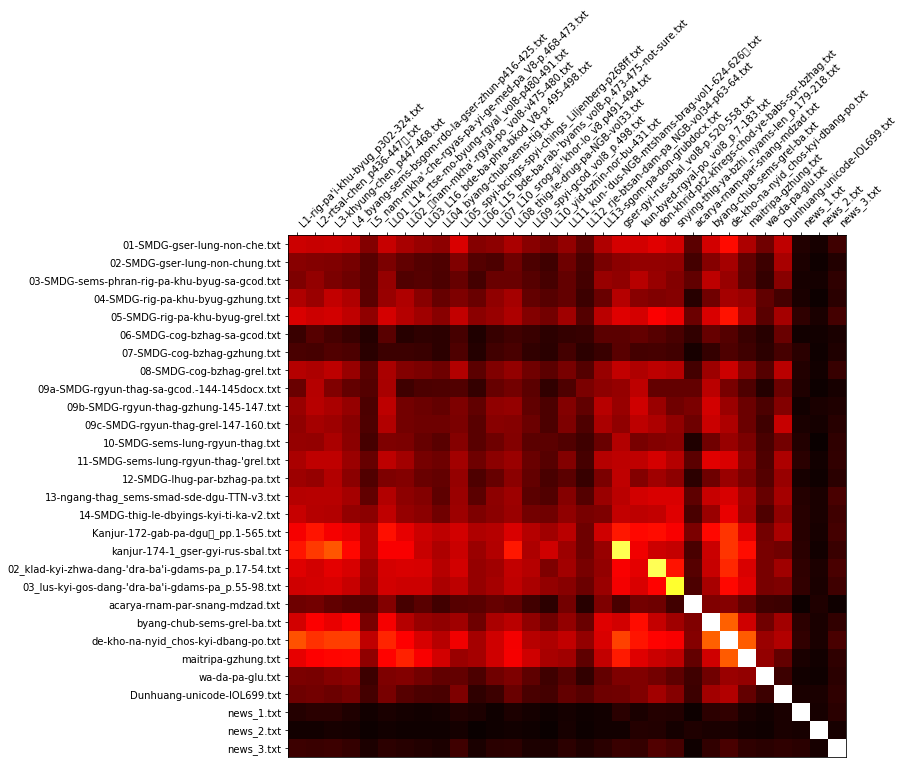

Bon + Bon large + Bon Dzogchen + Mahamudra + Dunhuang Chan + News vs Nyingma + Nyingma large + Nyingma Dzogchen + Mahamudra + Dunhuang Chan + News


In [23]:
run_one(bon_texts_f + bon_large_texts_f + bon_dzogchen_texts_f + mahamudra_texts_f + chan_texts_f + news_texts_f,
        nyingma_texts_f + nyingma_large_texts_f + nyingma_dzogchen_texts_f + mahamudra_texts_f + chan_texts_f + news_texts_f,
        "Bon + Bon large + Bon Dzogchen + Mahamudra + Dunhuang Chan + News",
        "Nyingma + Nyingma large + Nyingma Dzogchen + Mahamudra + Dunhuang Chan + News",
        bon_fnames + bon_large_fnames + bon_dzogchen_fnames + mahamudra_fnames + chan_fnames + news_fnames,
        nyingma_fnames + nyingma_large_fnames + nyingma_dzogchen_fnames + mahamudra_fnames + chan_fnames + news_fnames,
        bon_bigrams_f + bon_large_bigrams_f + bon_dzogchen_bigrams_f + mahamudra_bigrams_f + chan_bigrams_f + news_bigrams_f,
        nyingma_bigrams_f + nyingma_large_bigrams_f + bon_dzogchen_bigrams_f + mahamudra_bigrams_f + chan_bigrams_f + news_bigrams_f)


# Limited Vocabulary

In [24]:
vocab = ["བྱང་ཆུབ་སེམས",
"བྱང་ཆུབ་སྙིང་པོ",
"ཆོས་ཉིད",
"ཆོས་དབྱིངས",
"ཆོས་སྐུ",
"བོན་སྐུ",
"ཡེ་ཤེས",
"གཏི་མུག",
"སྐུ་དང་ཡེ་ཤེས",
"སེམས་ཉིད",
"རིག་པ",
"སྦྱོར་བ",
"རྟོགས་པ",
"སངས་རྒྱས་པ",
"སྐུ་གསུང་ཐུགས",
"གཉིས་མེད",
"མི་འགྱུར",
"ལས་འདས",
"མི་རྟོག",
"རང་འབྱུང",
"ཐིག་ལེ་གཅིག",
"བདེ་བ་ཆེན་པོ",
"སེམས་ཉིད",
"མཉམ་ཉིད",
"སངས་རྒྱས",
"ཁྱུང",
"སེང་གེ",
"ཐག་བཅད",
"ངོ་བོ་ཉིད",
"བསམ་གཏན",
"ཞི་གནས",
"ལྷག་མཐོང",
"ཚུལ་ཁྲིམས",
"གཤེན་ལྷ་འོད་དཀར",
"རྡོ་རྗེ་སེམས་དཔའ",
"དཀྱིལ་འཁོར",
"བདུད་རྩི"]

def read_raw(text_dir):
    texts = []
    for filename in sorted(os.listdir(text_dir)):
        if ".txt" in filename:
            with open(os.path.join(text_dir, filename), 'r', encoding='utf-8-sig') as f:
                texts.append(f.read())
    return texts

def vectorize_texts_limited(texts):
    vecs = []
    for t in texts:
        vec = np.array([len(re.findall(r"{}".format(v), t)) for v in vocab])
        vecs.append(vec)
    return vecs

def run_one_limited(c1_raw, c2_raw, c1_name, c2_name, c1_fnames, c2_fnames, abs_color=False):
    c1 = vectorize_texts_limited(c1_raw)
    c2 = vectorize_texts_limited(c2_raw)
    plot_one(c1, c2, c1_fnames, c2_fnames, k=cos_sim, c1_name=c1_name, c2_name=c2_name, c1_second=[], c2_second=[], abs_color=abs_color)
    

In [25]:
bon_raw = read_raw("texts/Bon")
nyingma_raw = read_raw("texts/Nyingma")
bon_large_raw = read_raw("texts/Bon-Large")
nyingma_large_raw = read_raw("texts/Nyingma-Large")
bon_dzogchen_raw = read_raw("texts/Bon-Dzogchen")
nyingma_dzogchen_raw = read_raw("texts/Nyingma-Dzogchen")
nyingma_gn_raw = read_raw("texts/Nyingma-GN")
news_raw = read_raw("texts/News")
mahamudra_raw = read_raw("texts/Mahamudra")
vairo_raw = read_raw("texts/Vairo")
chan_raw = read_raw("texts/Dunhuang-Chan")
dunhuang_raw = read_raw("texts/Dunhuang")


## Bon vs self

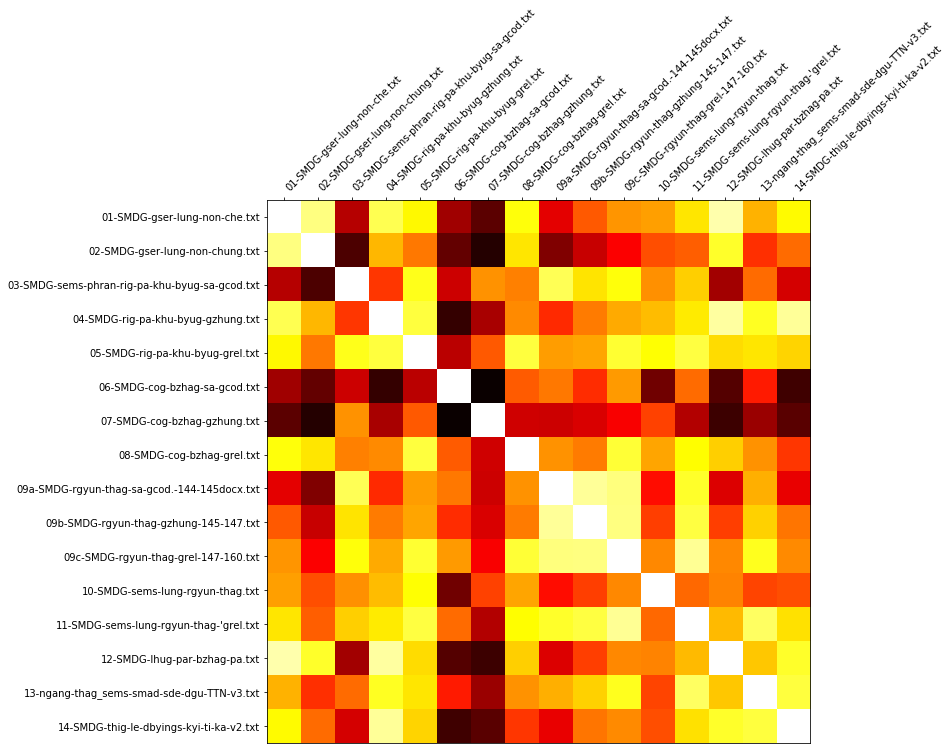

Bon vs Bon


In [26]:
run_one_limited(bon_raw, bon_raw, "Bon", "Bon", bon_fnames, bon_fnames)

## Nyingma vs self

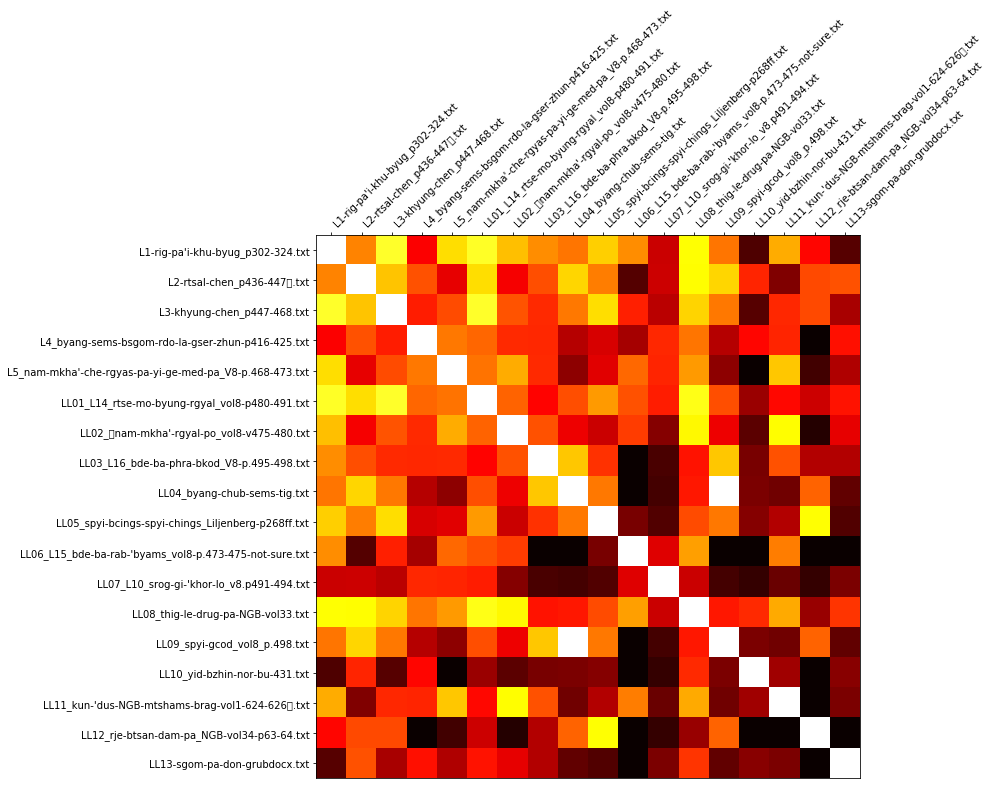

Nyingma vs Nyingma


In [27]:
run_one_limited(nyingma_raw, nyingma_raw, "Nyingma", "Nyingma", nyingma_fnames, nyingma_fnames)

## Nyingma vs Gdams Ngag songs (relative)

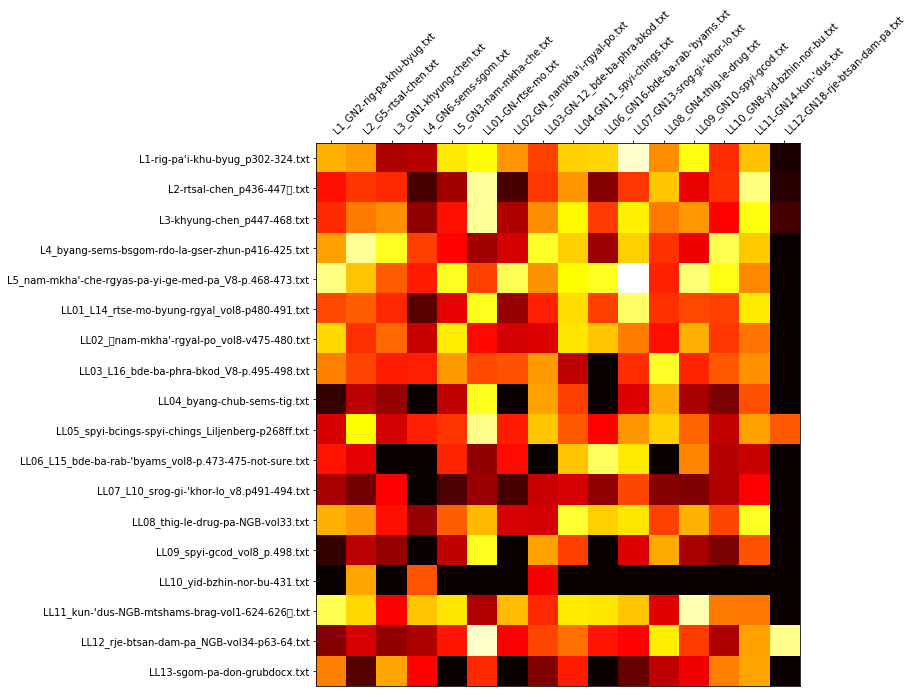

Nyingma vs Nyingma Gdams Ngag


In [28]:
run_one_limited(nyingma_raw, nyingma_gn_raw, "Nyingma", "Nyingma Gdams Ngag", nyingma_fnames, nyingma_gn_fnames)

## Nyingma vs Gdams Ngag songs (absolute)

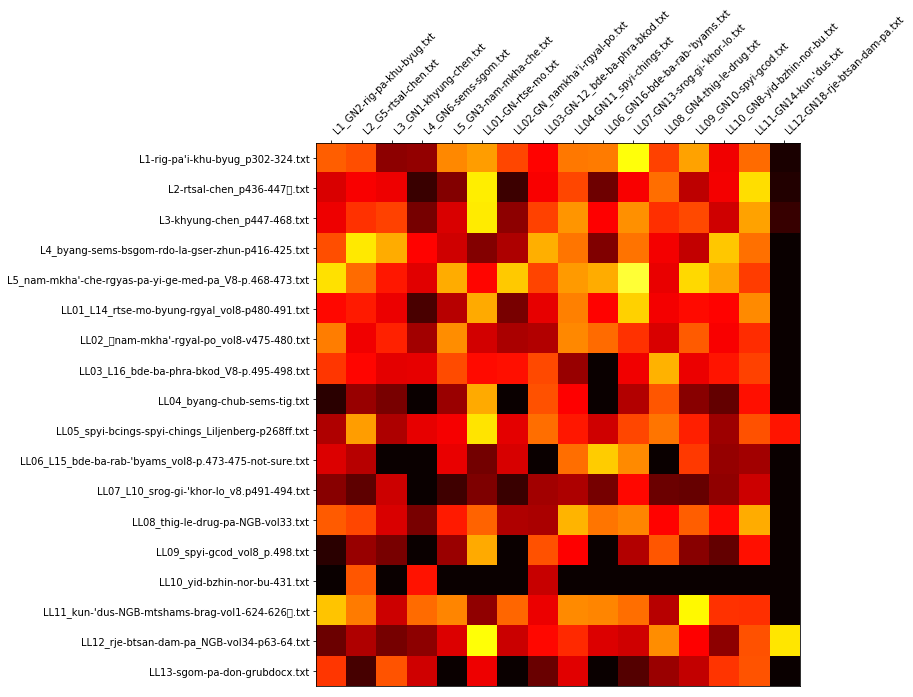

Nyingma vs Nyingma Gdams Ngag


In [29]:
run_one_limited(nyingma_raw, nyingma_gn_raw, "Nyingma", "Nyingma Gdams Ngag", nyingma_fnames, nyingma_gn_fnames, abs_color=True)

## 5 earlier Nyingma vs Vairo (relative)

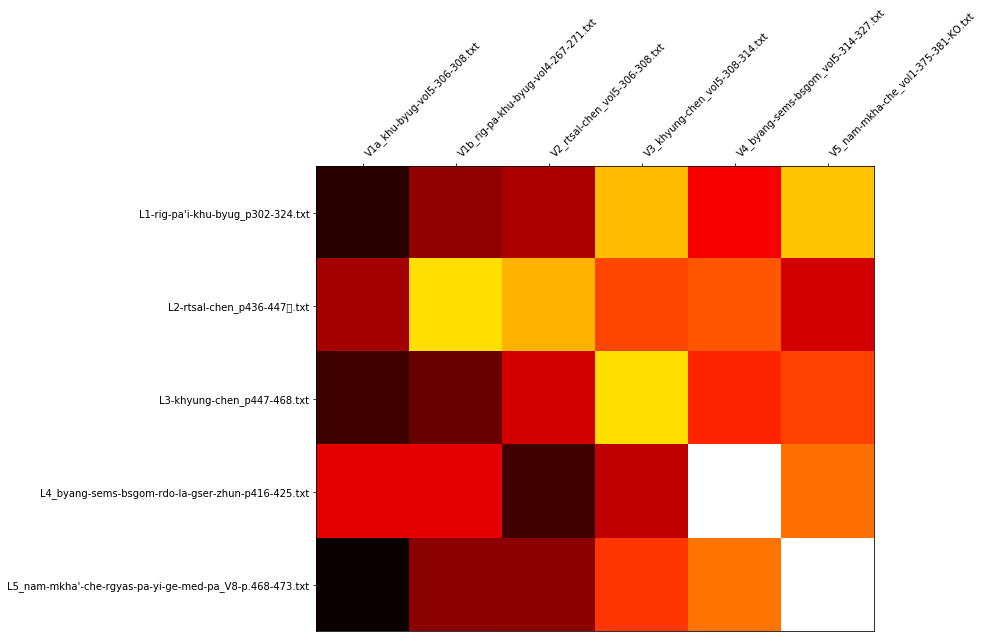

5 earlier Nyingma vs Vairo


In [30]:
run_one_limited(nyingma_raw[:5], vairo_raw, "5 earlier Nyingma", "Vairo", nyingma_fnames[:5], vairo_fnames)

## 5 earlier Nyingma vs Vairo (absolute)

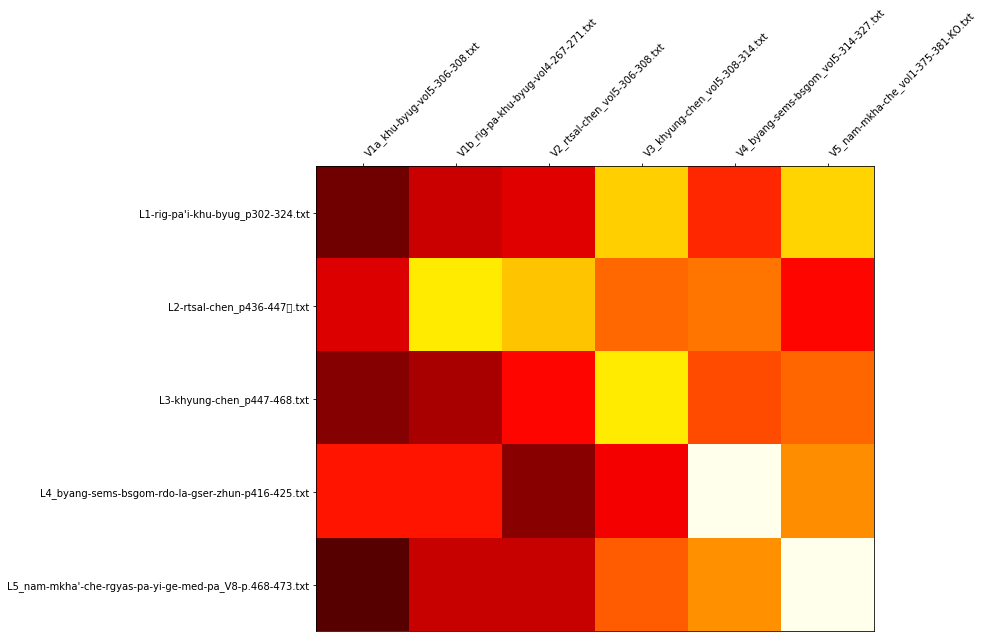

5 earlier Nyingma vs Vairo


In [31]:
run_one_limited(nyingma_raw[:5], vairo_raw, "5 earlier Nyingma", "Vairo", nyingma_fnames[:5], vairo_fnames, abs_color=True)

## 5 earlier Nyingma vs Bon (relative)

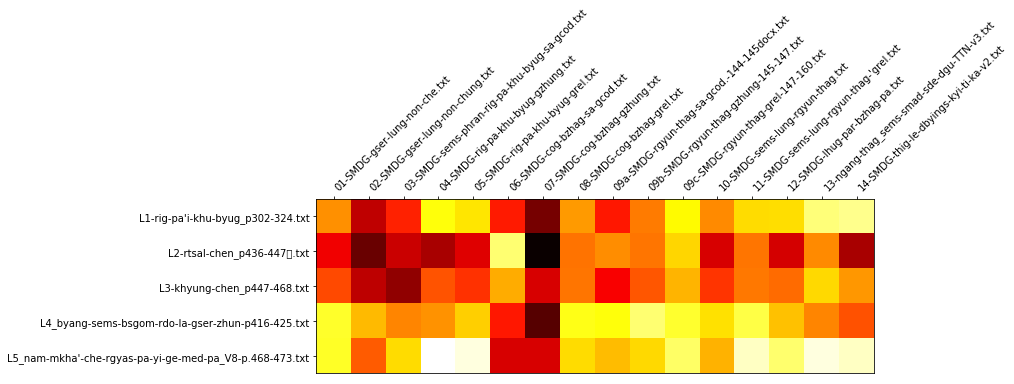

5 earlier Nyingma vs Bon


In [33]:
run_one_limited(nyingma_raw[:5], bon_raw, "5 earlier Nyingma", "Bon", nyingma_fnames[:5], bon_fnames)

## 5 earlier Nyingma vs Bon (absolute)

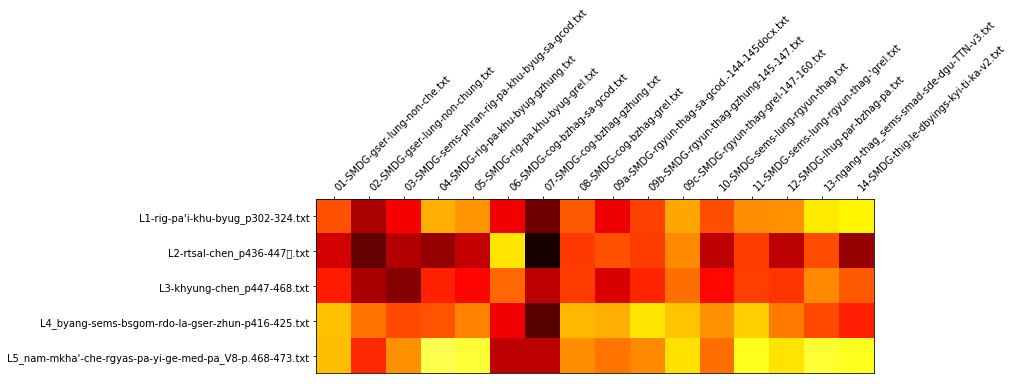

5 earlier Nyingma vs Bon


In [34]:
run_one_limited(nyingma_raw[:5], bon_raw, "5 earlier Nyingma", "Bon", nyingma_fnames[:5], bon_fnames, abs_color=True)

##  Vairo vs Bon (relative)

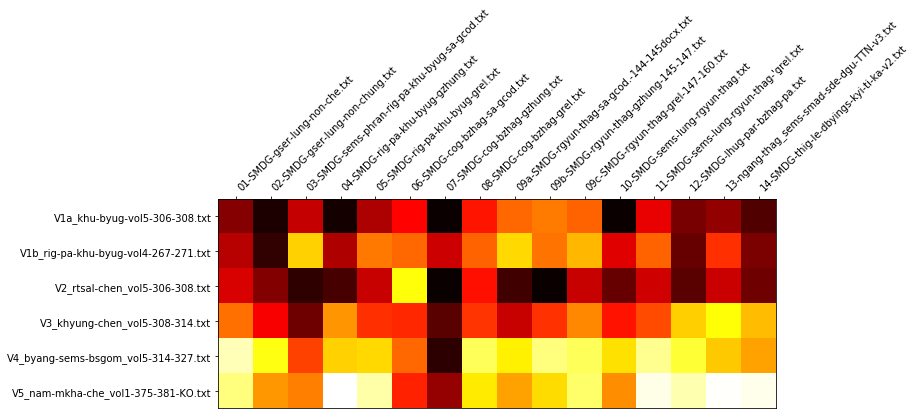

Vairo vs Bon


In [35]:
run_one_limited(vairo_raw, bon_raw, "Vairo", "Bon", vairo_fnames, bon_fnames)

##  Vairo vs Bon (absolute)

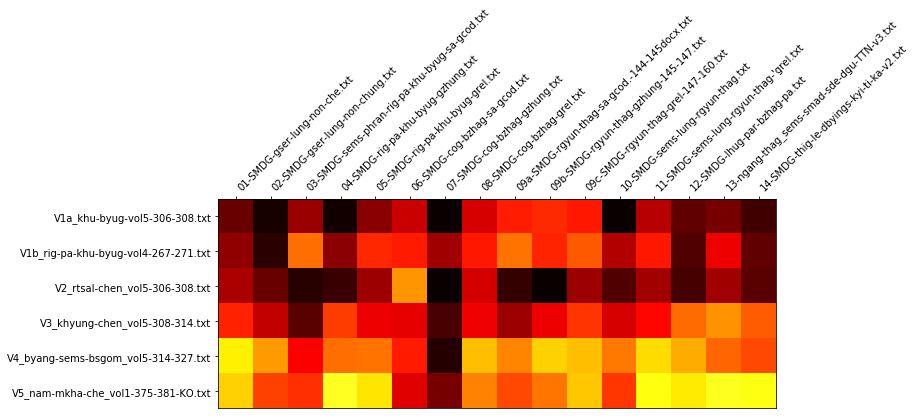

Vairo vs Bon


In [36]:
run_one_limited(vairo_raw, bon_raw, "Vairo", "Bon", vairo_fnames, bon_fnames, abs_color=True)

## Bon vs Nyingma (relative)

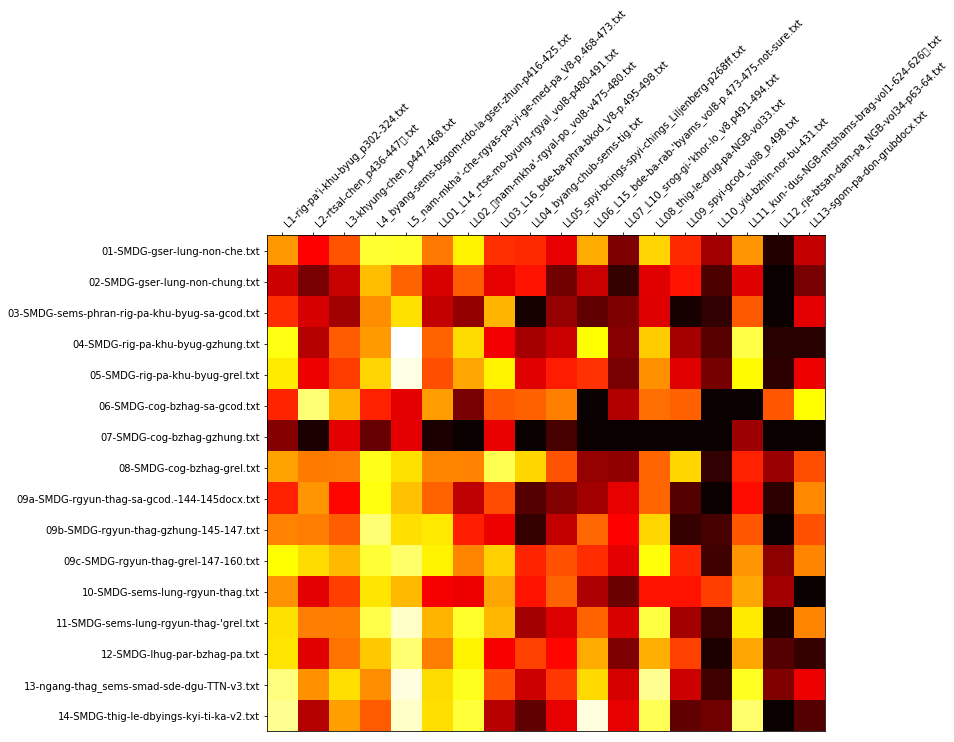

Bon vs Nyingma


In [37]:
run_one_limited(bon_raw, nyingma_raw, "Bon", "Nyingma", bon_fnames, nyingma_fnames)

## Bon vs Nyingma (absolute)

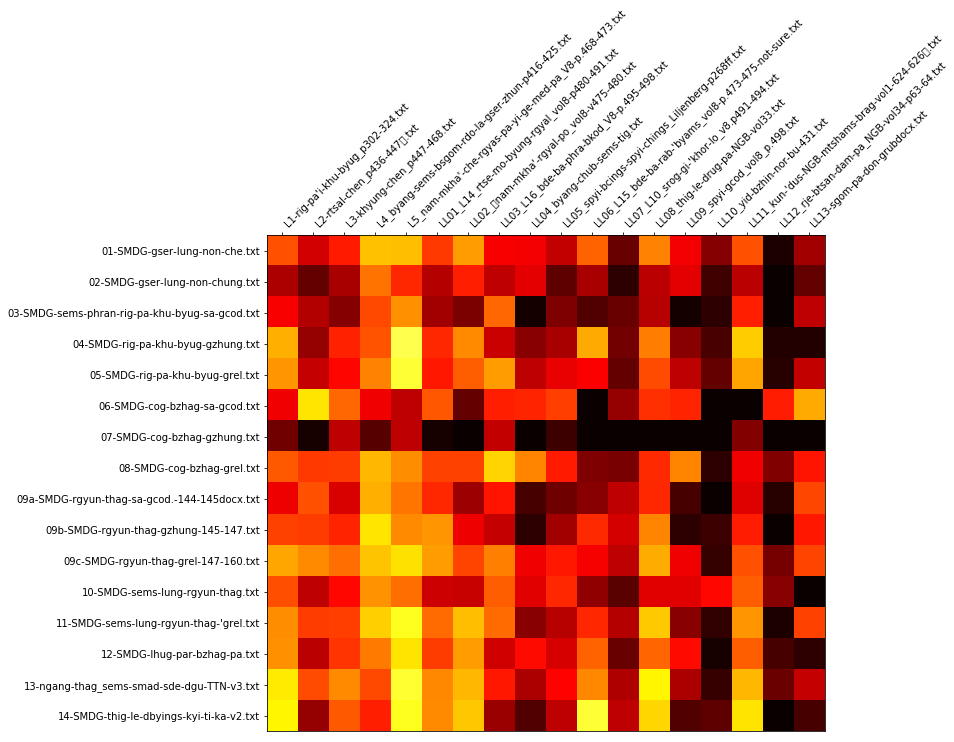

Bon vs Nyingma


In [38]:
run_one_limited(bon_raw, nyingma_raw, "Bon", "Nyingma", bon_fnames, nyingma_fnames, abs_color=True)

## Bon + Bon large vs Nyingma + Nyingma large (relative)

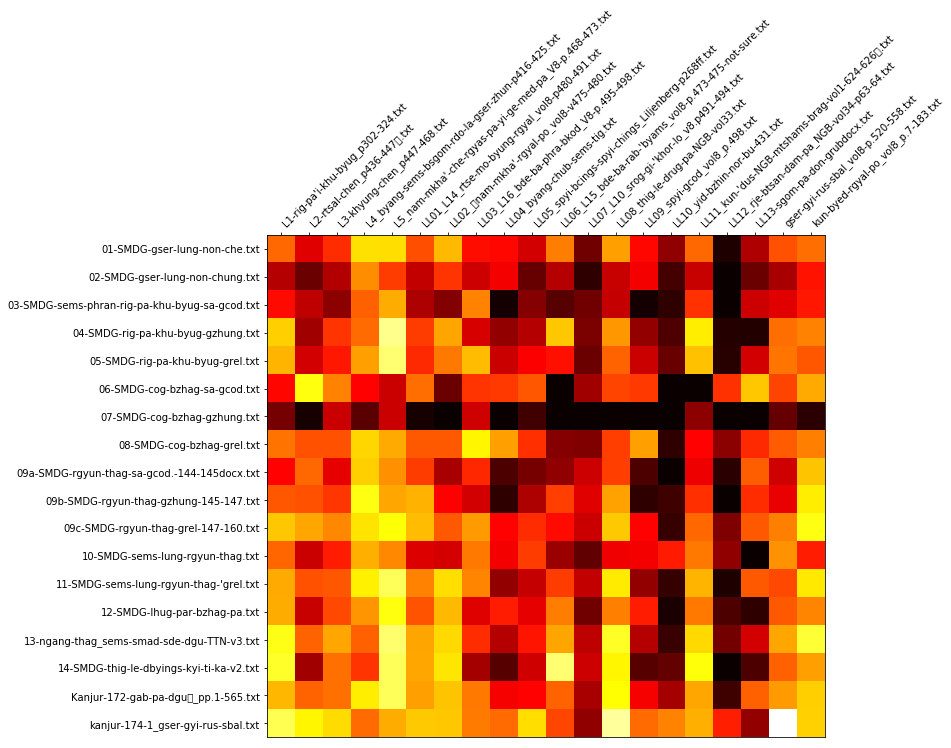

Bon + Bon large vs Nyingma + Nyingma large


In [39]:
run_one_limited(bon_raw + bon_large_raw, nyingma_raw + nyingma_large_raw, "Bon + Bon large", "Nyingma + Nyingma large", bon_fnames + bon_large_fnames, nyingma_fnames + nyingma_large_fnames)

## Bon + Bon large vs Nyingma + Nyingma large (absolute)

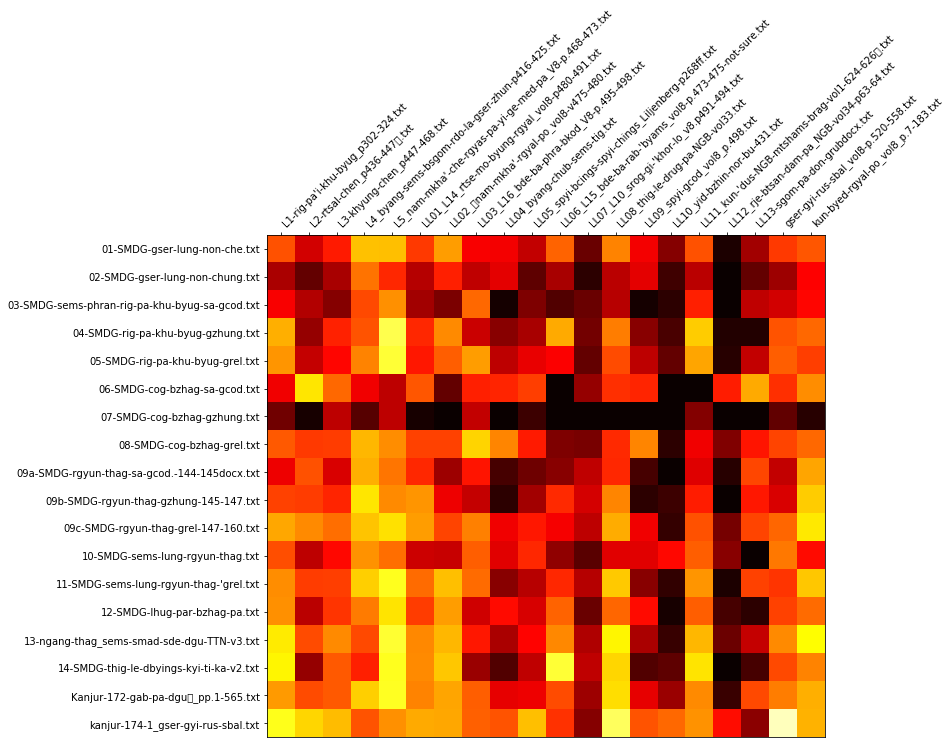

Bon + Bon large vs Nyingma + Nyingma large


In [40]:
run_one_limited(bon_raw + bon_large_raw, nyingma_raw + nyingma_large_raw, "Bon + Bon large", "Nyingma + Nyingma large", bon_fnames + bon_large_fnames, nyingma_fnames + nyingma_large_fnames, abs_color=True)

## Bon + Bon large + Bon dzogchen + Mahamudra + Dunhuang Chan vs Nyingma + Nyingma large + Nyingma dzogchen + Mahamudra + Dunhuang Chan

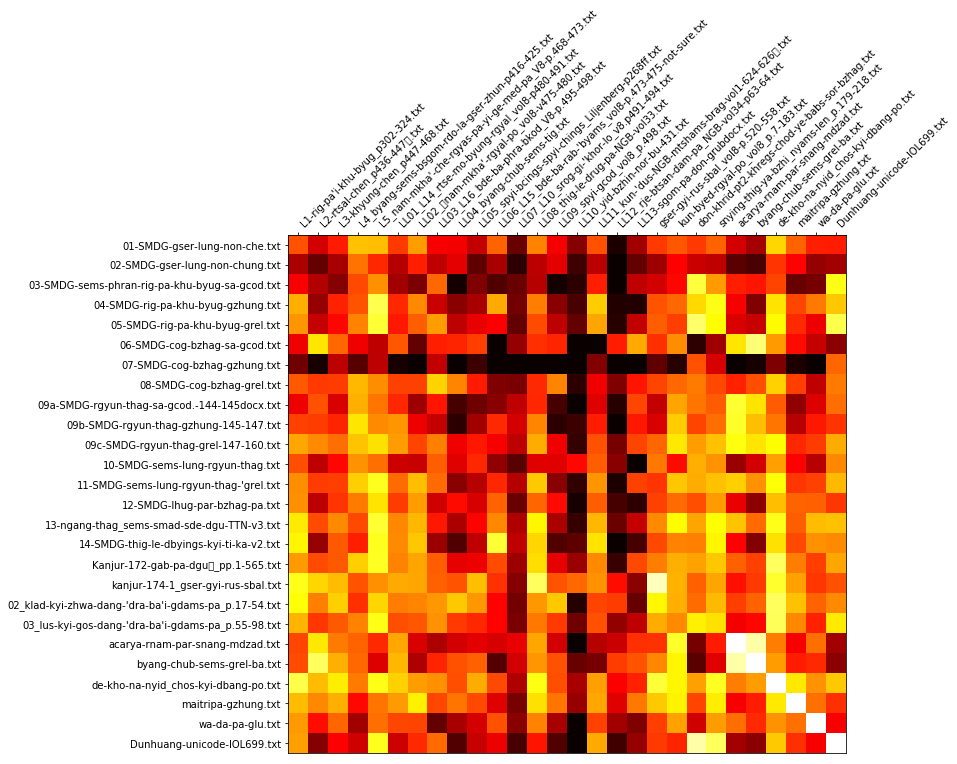

Bon + Bon large + Bon Dzogchen + Mahamudra + Dunhuang Chan vs Nyingma + Nyingma large + Nyingma Dzogchen + Mahamudra + Dunhuang Chan


In [41]:
run_one_limited(bon_raw + bon_large_raw + bon_dzogchen_raw + mahamudra_raw + chan_raw,
        nyingma_raw + nyingma_large_raw + nyingma_dzogchen_raw + mahamudra_raw + chan_raw,
        "Bon + Bon large + Bon Dzogchen + Mahamudra + Dunhuang Chan",
        "Nyingma + Nyingma large + Nyingma Dzogchen + Mahamudra + Dunhuang Chan",
        bon_fnames + bon_large_fnames + bon_dzogchen_fnames + mahamudra_fnames + chan_fnames,
        nyingma_fnames + nyingma_large_fnames + nyingma_dzogchen_fnames + mahamudra_fnames + chan_fnames)


## Bon + Bon large + Bon dzogchen + Mahamudra + Dunhuang Chan + News articles vs Nyingma + Nyingma large + Nyingma dzogchen + Mahamudra + Dunhuang Chan + News articles

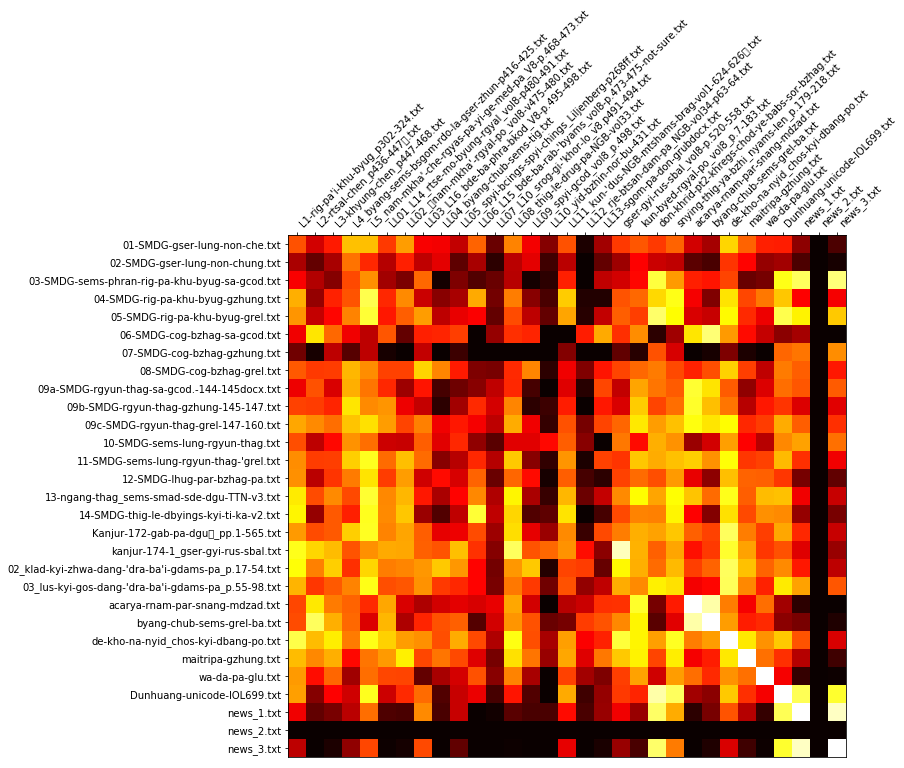

Bon + Bon large + Bon Dzogchen + Mahamudra + Dunhuang Chan + News vs Nyingma + Nyingma large + Nyingma Dzogchen + Mahamudra + Dunhuang Chan + News


In [42]:
run_one_limited(bon_raw + bon_large_raw + bon_dzogchen_raw + mahamudra_raw + chan_raw + news_raw,
        nyingma_raw + nyingma_large_raw + nyingma_dzogchen_raw + mahamudra_raw + chan_raw + news_raw,
        "Bon + Bon large + Bon Dzogchen + Mahamudra + Dunhuang Chan + News",
        "Nyingma + Nyingma large + Nyingma Dzogchen + Mahamudra + Dunhuang Chan + News",
        bon_fnames + bon_large_fnames + bon_dzogchen_fnames + mahamudra_fnames + chan_fnames + news_fnames,
        nyingma_fnames + nyingma_large_fnames + nyingma_dzogchen_fnames + mahamudra_fnames + chan_fnames + news_fnames)


In [43]:
dct = Dictionary(bon_texts_f + nyingma_texts_f + bon_large_texts_f + nyingma_large_texts_f
                 + bon_dzogchen_texts_f + nyingma_dzogchen_texts_f + mahamudra_texts_f + chan_texts_f + news_texts_f
                 + bon_bigrams_f + nyingma_bigrams_f + bon_large_bigrams_f + nyingma_large_bigrams_f
                 + bon_dzogchen_bigrams_f + nyingma_dzogchen_bigrams_f + mahamudra_bigrams_f + chan_bigrams_f + news_bigrams_f)

In [44]:
len(dct)

92937

In [45]:
dct = Dictionary(bon_texts_f + nyingma_texts_f + bon_large_texts_f + nyingma_large_texts_f
                 + bon_dzogchen_texts_f + nyingma_dzogchen_texts_f + mahamudra_texts_f + chan_texts_f
                 + bon_bigrams_f + nyingma_bigrams_f + bon_large_bigrams_f + nyingma_large_bigrams_f
                 + bon_dzogchen_bigrams_f + nyingma_dzogchen_bigrams_f + mahamudra_bigrams_f + chan_bigrams_f)

In [46]:
len(dct)

87973

In [47]:
dct = Dictionary(bon_texts_f + nyingma_texts_f + bon_large_texts_f + nyingma_large_texts_f
                 + bon_bigrams_f + nyingma_bigrams_f + bon_large_bigrams_f + nyingma_large_bigrams_f)

In [48]:
len(dct)

40366

In [49]:
dct = Dictionary(bon_texts_f + nyingma_texts_f
                 + bon_bigrams_f + nyingma_bigrams_f)

In [50]:
len(dct)

21974